In [126]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt

def estimate_m_values(data, strain_rate_columns, strain_rates):
    """
    Estimate m values for each strain by fitting a linear regression to log-log data and visualize the results.
    """
    m_values = []
    
    for i in range(len(data)):
        # Extract stress values for different strain rates for the current row
        stress_values = data.iloc[i][strain_rate_columns].values
        
        # Apply log transformation to stress and strain rates
        log_stress = np.log(stress_values)
        log_strain_rates = np.log(strain_rates / 0.0001)
        
        # Perform linear regression to estimate m
        slope, intercept, r_value, p_value, std_err = linregress(log_strain_rates, log_stress)
        
        # Append the estimated m and corresponding strain
        m_values.append({
            'strain': data['strain'].iloc[i],
            'm_estimated': slope
        })
    
    df = pd.DataFrame(m_values)
    df.to_csv('m_values.csv', index=False)
    return df

def plot_stress(data, m_values, strain_rates, strain_rate_columns):
    """
    Plot real vs. predicted stress for given strain rates.
    """
    ref_stress = data[strain_rate_columns[0]]  # Reference column (StrRt0.0001)
    strain = data['strain']

    for strain_rate, col in zip(strain_rates, strain_rate_columns):
        fitted_stress = ref_stress * (strain_rate / strain_rates[0]) ** m_values
        real_stress = data[col]
        plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
        plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
        plt.xlabel('Strain')
        plt.ylabel('Stress')
        plt.title(f'Real vs Predicted Stress for StrRt{strain_rate}')
        plt.legend()
        plt.show()


def process_temperature_file(temperature_file, strain_rate_columns, strain_rates):
    """
    Process a temperature-specific file to estimate m values, plot stress data, fit the m function,
    and display the results.

    Parameters:
    - temperature_file (str): Path to the CSV file for the temperature.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    - strain_rates (list of float): List of strain rate values.

    Returns:
    - Fitted parameters for the m function.
    """
    try:
        # Load the temperature-specific file
        data = pd.read_csv(temperature_file)
        
        # Step 1: Estimate m values for each strain
        m_values_df = estimate_m_values(data, strain_rate_columns, strain_rates)
        
        # Plot real vs. predicted stress
        plot_stress(data, m_values_df['m_estimated'], strain_rates, strain_rate_columns)
        
        # Step 2: Fit the m function to the estimated m values
        fitted_params = fit_m_function(m_values_df)
        
        # Print fitted parameters
        print(f"Fitted parameters [a, b, c, d, e] for {temperature_file}:", fitted_params)
        
        # Plot estimated m values and fitted function
        plt.scatter(m_values_df['strain'], m_values_df['m_estimated'], label='Estimated m values', color='red')
        '''
        plt.plot(m_values_df['strain'], 
                 fitted_params[0] * (fitted_params[1] * m_values_df['strain'] / (m_values_df['strain'] ** fitted_params[2] + fitted_params[3]) + fitted_params[4]),
                 label='Fitted m function', color='blue')
        '''
        plt.plot(m_values_df['strain'], 
                 fitted_params[0] *  m_values_df['strain']**fitted_params[1],
                 label='Fitted m function', color='blue')
        plt.xlabel('Strain')
        plt.ylabel('Estimated m')
        plt.legend()
        plt.title(f'Fitting m Function to Estimated m Values for {temperature_file}')
        plt.show()
        
        return fitted_params
    
    except FileNotFoundError:
        print(f"File {temperature_file} not found.")
    except Exception as e:
        print(f"An error occurred while processing {temperature_file}: {e}")

def fit_m_function(m_values_df):
    """
    Fit the function m(strain) to the estimated m values to find a, b, c, d, e.
    """
    # Define the m function
    def m_function(strain, a,b):
        epsilon = 1e-10  # A very small positive value
        return a * (strain + epsilon)**b
    
    # Perform curve fitting
    params, _ = curve_fit(
        m_function,
        m_values_df['strain'],
        m_values_df['m_estimated'],
        p0=[0.001, -0.5],  # Initial guess for [a, b, c, d, e]
        bounds=([1e-5, -0.9], [10, 0.9]), # Lower and upper bounds for [a, b, c]
        maxfev=100000
    )
    
    return params
# Example usage
temperature_file = 'Tmp298.15_RD.csv'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1, 1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']

process_temperature_file(temperature_file, strain_rate_columns, strain_rates)

An error occurred while processing Tmp298.15_RD.csv: unsupported operand type(s) for /: 'list' and 'float'


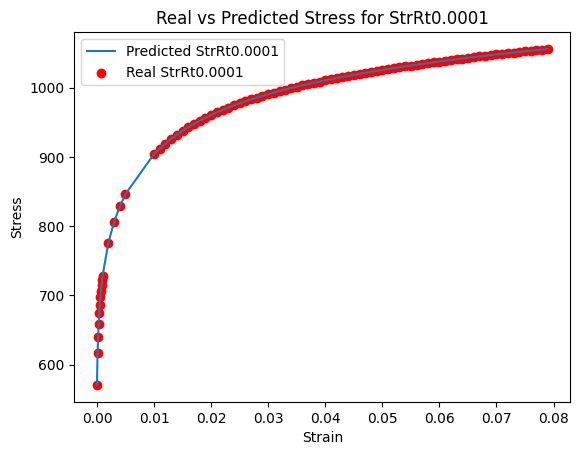

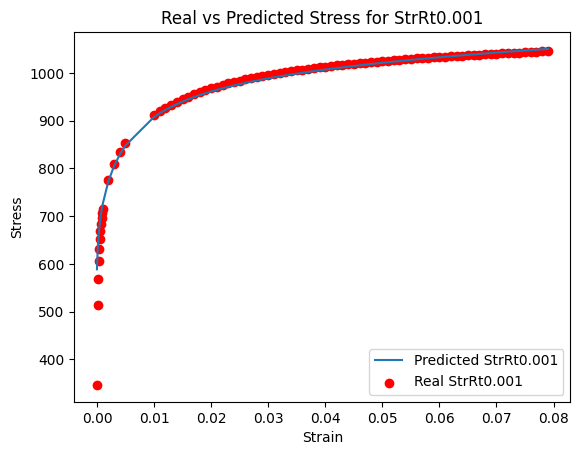

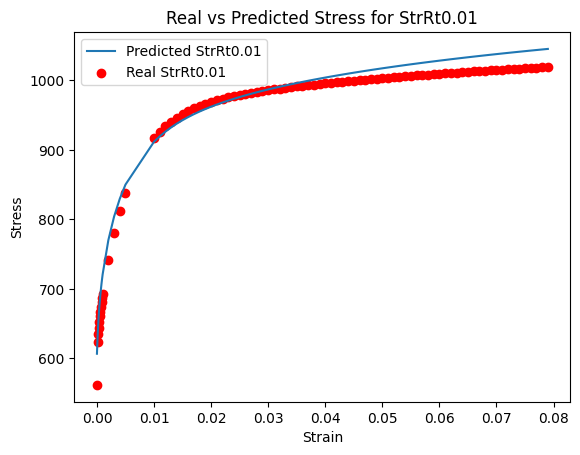

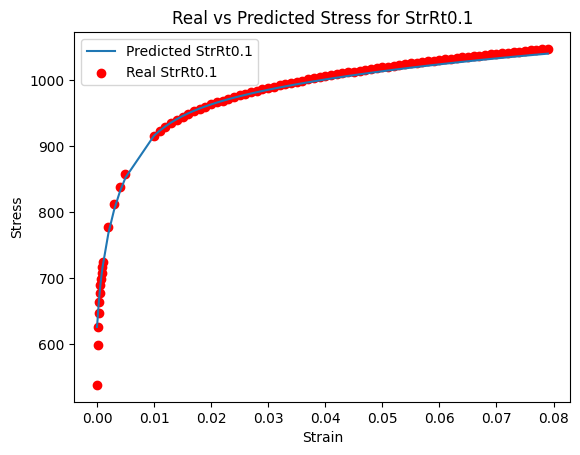

Fitted parameters [a, b, c, d, e] for Tmp373.15_RD.csv: [ 0.001 -0.5    0.   ]


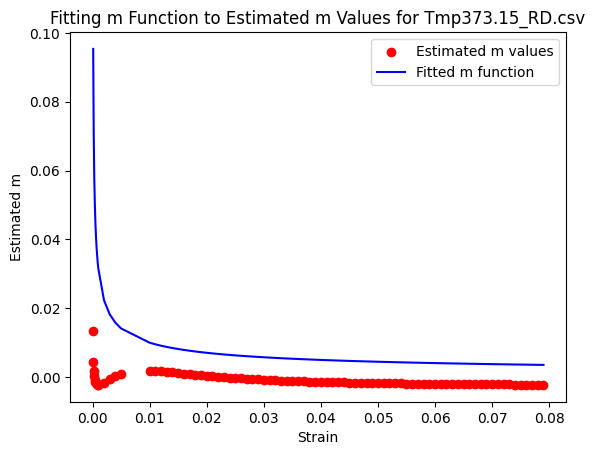

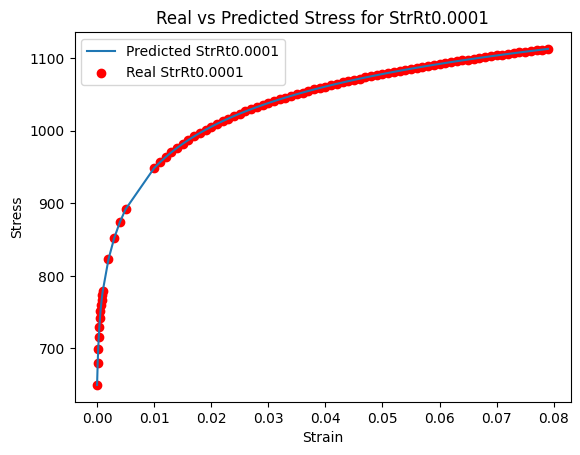

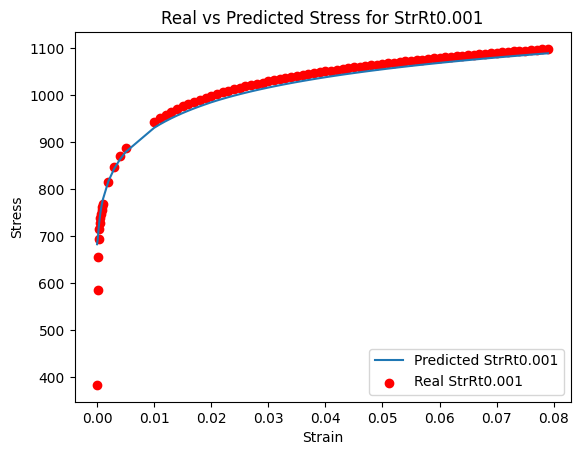

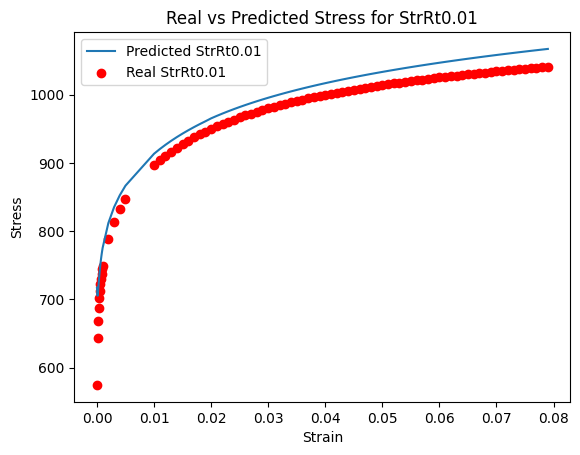

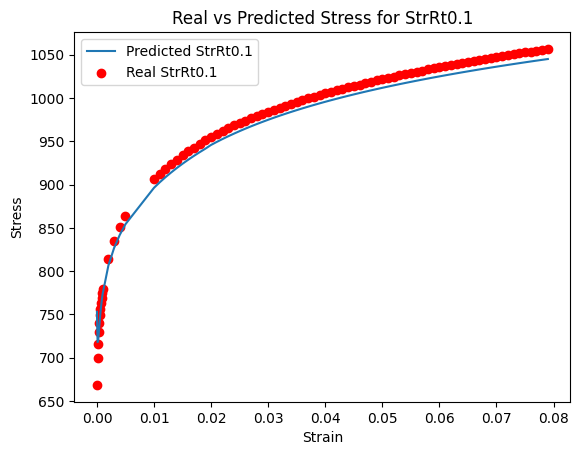

Fitted parameters [a, b, c, d, e] for Tmp473.15_RD.csv: [ 0.001 -0.5    0.   ]


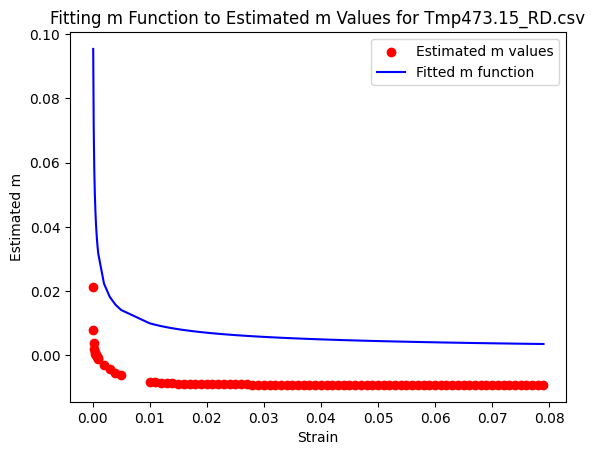

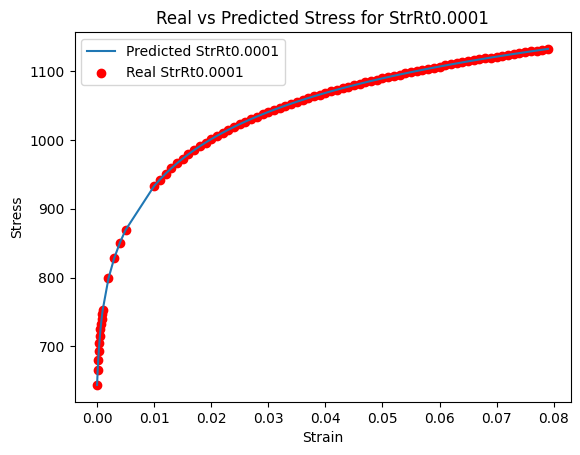

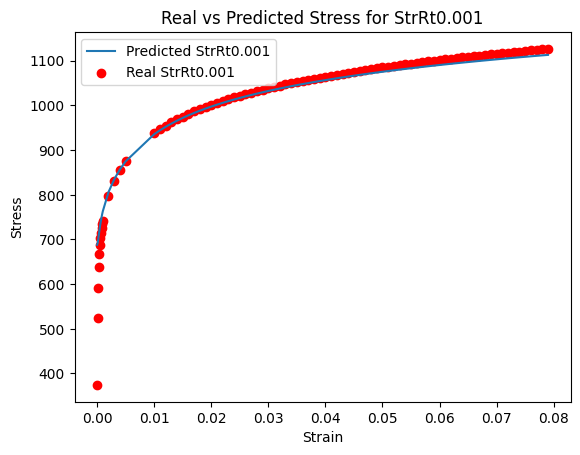

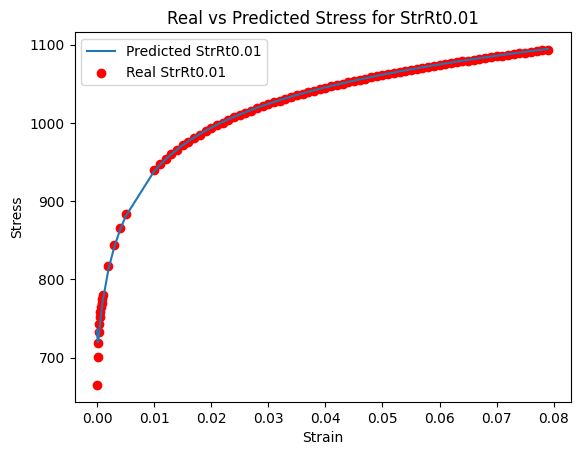

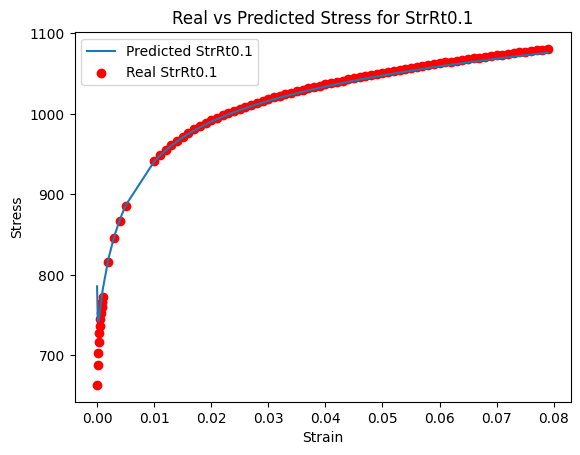

Fitted parameters [a, b, c, d, e] for Tmp573.15_RD.csv: [ 0.001 -0.5    0.   ]


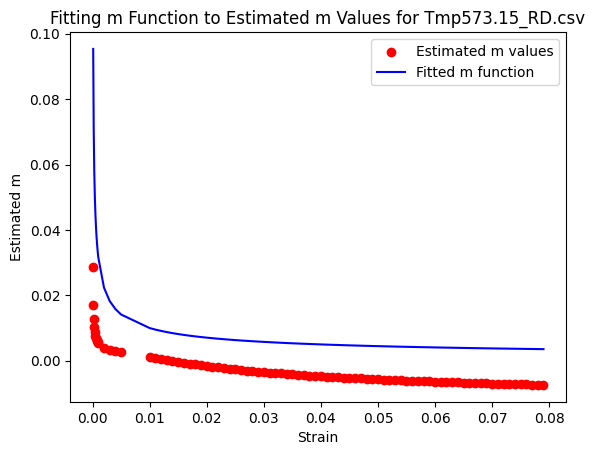

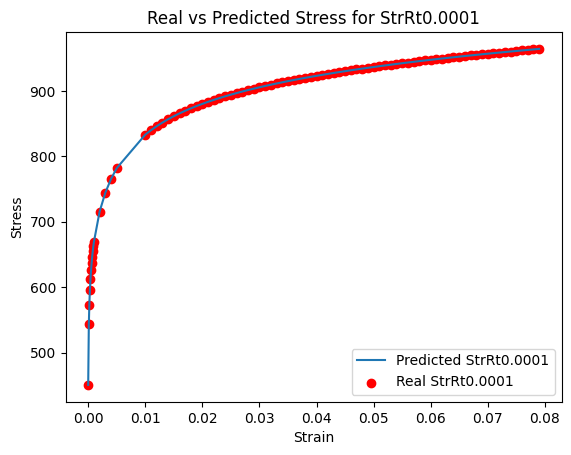

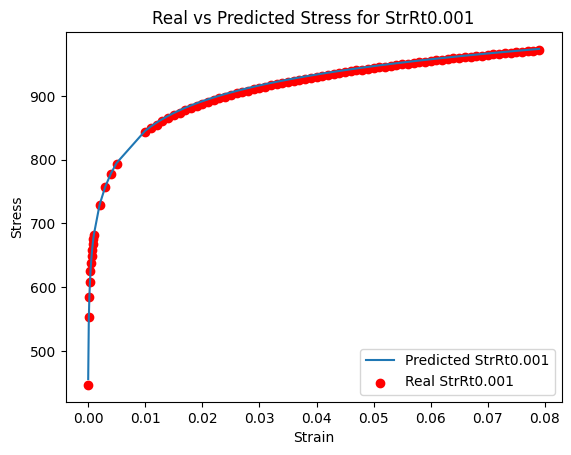

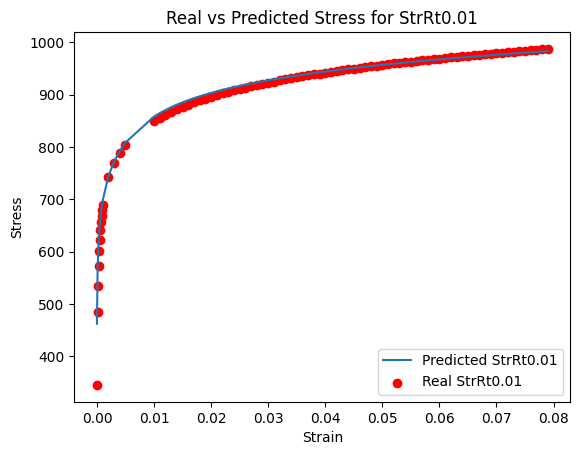

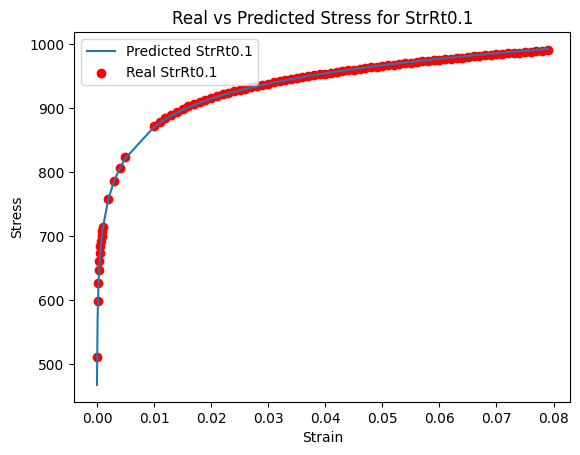

Fitted parameters [a, b, c, d, e] for Tmp673.15_RD.csv: [ 0.001 -0.5    0.   ]


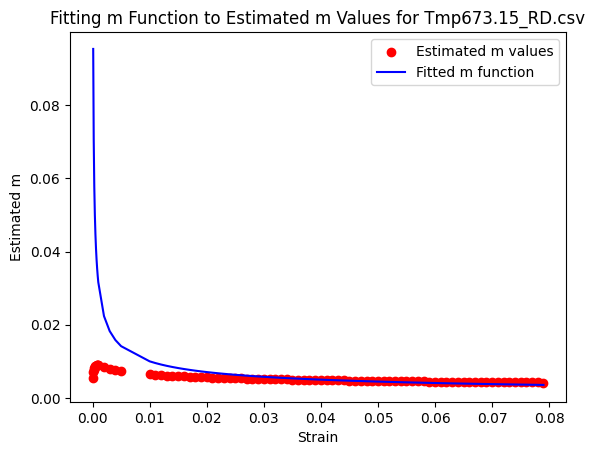

In [120]:
temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['StrRt0.0001', 'StrRt0.001', 'StrRt0.01', 'StrRt0.1']

for temp in temps:
    process_temperature_file(f"Tmp{temp}_RD.csv", strain_rate_columns, strain_rates)